# Compulsory Assignment 2: Convolutional neural networks

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 22\
**Group member 1**: Martine Sørgård Olsen\
**Group member 2**: Andrea Øwre\
**Group member 3**: Mathilde Haglund\
**Group name (optional)**: Dream team

Make sure that the group name given in the assignment is the same that you use on the Kaggle Leaderboard.

# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignment is submitted by handing in this notebook as an .ipynb file and as a .pdf file. In addition, you are required to submit at least one test prediction to the Kaggle leaderboard that is better than the *BEAT ME* score. And, for fun see if you can beat the SandvikNet submission score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit. 

# Introduction 
This assignment will start with classifying handwritten digits from the MNIST dataset, used in the voluntary assignment and the first compulsory assignment. The second part of this task will revolve around classifying the open-source CIFAR-10 dataset.

## CIFAR-10

The CIFAR-10 dataset is a labeled subsets of the [80 million tiny images dataset](http://groups.csail.mit.edu/vision/TinyImages/). The images were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60 000 32x32 RGB images with partitioned into 10 classes depicted below.

<center><img src="cifar_10_illustration.png" width="500" height="400"></center>

Each annotation class contains 6 000 images. You will be provided `X_train` with 50 000 annotated samples, and `X_test` with 10 000 unlabelled samples.

## Assignment structure

1. Part 1: Implementing LeNet for classifying MNIST.
2. Part 2: Designing your own CNN for classifying CIFAR-10

## Submissions to the Kaggle leaderboard
Use the following code to create the `submission.csv` file that you can submit to the Kaggle leaderboard. 

```python
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.
```

## Library imports

In [30]:
# Feel free to add or remove libraries as you want
import time
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as ks
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

from utilities import *

import warnings
warnings.filterwarnings('ignore', 'TensorFlow Addons.*', category=UserWarning)

# Part 1: CNN for classifying the MNIST dataset

## Loading MNIST

In [10]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

## Preprocessing

In [11]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test  = ks.utils.to_categorical(y_test, len(np.unique(y_test)))

## Task 1.1: Build a network with the LeNet CNN architecture

### Task 1.1.1 Building network

Implement the famous LeNet architecture according to the following specifications: 

--------------------------
The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU. 

**MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU. 

**MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.

--------------------------

Compile the network with the
* `tf.keras.losses.CategoricalCrossentropy` loss function (wrote `MSE` loss before)
* the `adam` optimizer 
* with the `accuracy` metric and (your own implementation of the) F1-score metric.

In [12]:
def build_LeNet():
    # Input layer
    input_img = ks.layers.Input(shape=(28, 28, 1))
    
    # Layer 1 - Convolution (5x5)
    x = ks.layers.Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
    
    # MaxPooling
    x = ks.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 2 - Convolution (5x5)
    x = ks.layers.Conv2D(16, kernel_size=(5, 5), activation='relu')(x)
    
    # MaxPooling
    x = ks.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten
    x = ks.layers.Flatten()(x)
    
    # Layer 3 - Fully Connected
    x = ks.layers.Dense(120, activation='relu')(x)
    
    # Layer 4 - Fully Connected
    x = ks.layers.Dense(84, activation='relu')(x)
    
    # Layer 5 - Fully Connected
    output = ks.layers.Dense(10, activation='softmax')(x)
    
    # Create the model
    model = ks.models.Model(inputs=input_img, outputs=output)
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss=ks.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=10, average='macro')])
    
    return model

# Create the LeNet model
lenet_model = build_LeNet()

# Display the model's architecture
lenet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 400)               0   

### Task 1.1.2 Train network

Train the network with a 
* batch size of 128 samples
* for 40 epochs
* 1/6 validation split

In [13]:
# Training the LeNet model
history = lenet_model.fit(X_train, y_train,
                          batch_size=128,
                          epochs=40,
                          validation_split=0.1667,
                          verbose=1)

# Once training is done, you can use the 'history' object to plot training/validation loss and accuracy.

Epoch 1/40
391/391 [==============================] - 25s 54ms/step - loss: 0.3323 - accuracy: 0.8998 - f1_score: 0.8987 - val_loss: 0.1037 - val_accuracy: 0.9684 - val_f1_score: 0.9682
Epoch 2/40
391/391 [==============================] - 21s 53ms/step - loss: 0.0889 - accuracy: 0.9727 - f1_score: 0.9725 - val_loss: 0.0771 - val_accuracy: 0.9771 - val_f1_score: 0.9769
Epoch 3/40
391/391 [==============================] - 21s 54ms/step - loss: 0.0653 - accuracy: 0.9792 - f1_score: 0.9791 - val_loss: 0.0587 - val_accuracy: 0.9820 - val_f1_score: 0.9819
Epoch 4/40
391/391 [==============================] - 21s 53ms/step - loss: 0.0493 - accuracy: 0.9844 - f1_score: 0.9843 - val_loss: 0.0516 - val_accuracy: 0.9842 - val_f1_score: 0.9841
Epoch 5/40
391/391 [==============================] - 21s 55ms/step - loss: 0.0417 - accuracy: 0.9866 - f1_score: 0.9865 - val_loss: 0.0545 - val_accuracy: 0.9829 - val_f1_score: 0.9828
Epoch 6/40
391/391 [==============================] - 21s 55ms/step - 

### Task 1.1.3 Plot training history

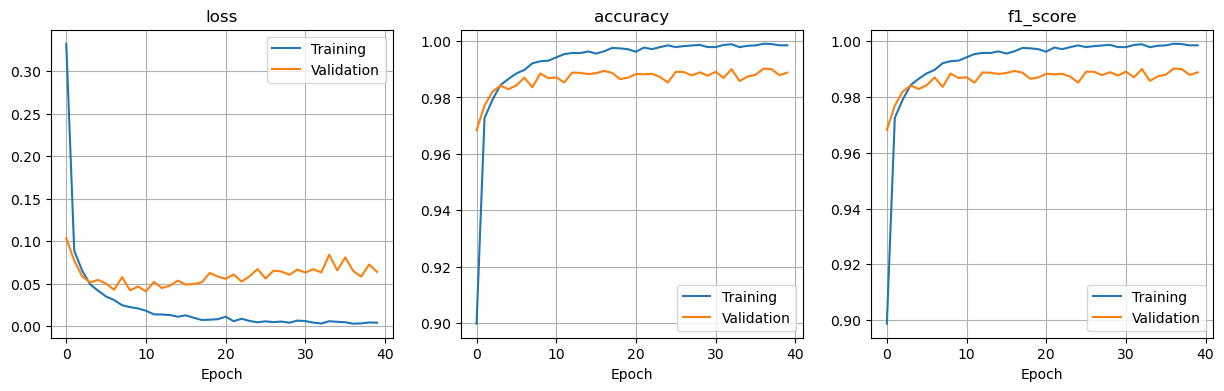

In [14]:
# Plotting the training history
plot_training_history(history)

### Task 1.1.4 Evaluate on the test dataset

In [15]:
# Evaluate the model on the test data
loss, accuracy, f1_score = lenet_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1_score:.4f}")

313/313 [==============================] - 3s 11ms/step - loss: 0.0563 - accuracy: 0.9888 - f1_score: 0.9887
Test Loss: 0.0563
Test Accuracy: 0.9888
Test F1-Score: 0.9887


## Task 1.2: MNIST discussion

**Task 1.2.1: Does overfitting occur? If so, after how many epochs?**

Considering the data, one might suggest that overfitting begins after epoch 33 since the model doesn't significantly improve on the validation dataset but continues to improve on the training dataset. The validation accuracy (val_accuracy) sees its highest value around epoch 33 with a value of 0.9900. After this epoch, the validation accuracy doesn't show consistent improvement and fluctuates with occasional dips. The training accuracy (accuracy) is constantly improving or staying relatively stable across epochs.

**Task 1.2.2: How do the results of the LeNet implementation compare to the results of your models from CA1?**

The model in this assignment is a slight worse performer than the best performer from CA1. The accuracy in CA2 was 98.9%, while the accuracy in CA1 was 99.2%.


**Task 1.2.3: Given the accuracy that your implementation of the LeNet attained on the test-dataset, what would the expected error-rate be if your model was appplied to read 10-digit handwritten number?**

First, determine the error rate for a single digit:

$\text{Error rate} = 1 - \text{Accuracy}$
 
If we take the accuracy from the last epoch as a representation (0.9888), then: 

$\text{Error rate} = 1 - 0.9888 = 0.0112$

For a 10-digit number, the chance of making at least one mistake when reading the entire number is: 

$\text{(Probability of at least one error in 10 digits)} = 1 - \text{(Probability of no errors in 10 digits)} 
\\= 1 - (1 - \text{Error rate})^{10}
\\ \approx 1 - (1 - 0.112)^{10}
\\ \approx 0.1076 
\\ \approx 10.76\%$ 

Hence, the expected error rate when reading a 10-digit handwritten number with this model would be approximately 10.76%. Note that this calculation assumes that the errors in reading each digit are independent. 

# Task 2: CNN for classifying the CIFAR-10 dataset

In this task you shall implement a CNN model, and train it to classify the images in the CIFAR-10 dataset.

## Importing CIFAR-10

Make sure file `student_dataset_CIFAR10.h5` is in the same directory as this notebook. Or you can edit the path from where it is read from. 

In [16]:
dataset_path = './student_dataset_CIFAR10.h5'

with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test  = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 50000
Nr. test images: 10000


## Task 2.1: Preprocess the data

Preprocess the data as you see fit

In [18]:
# 1. Normalization
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 2. One-Hot Encoding
y_train = to_categorical(y_train, 10)

## Task 2.2: Visualize the dataset

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant. 

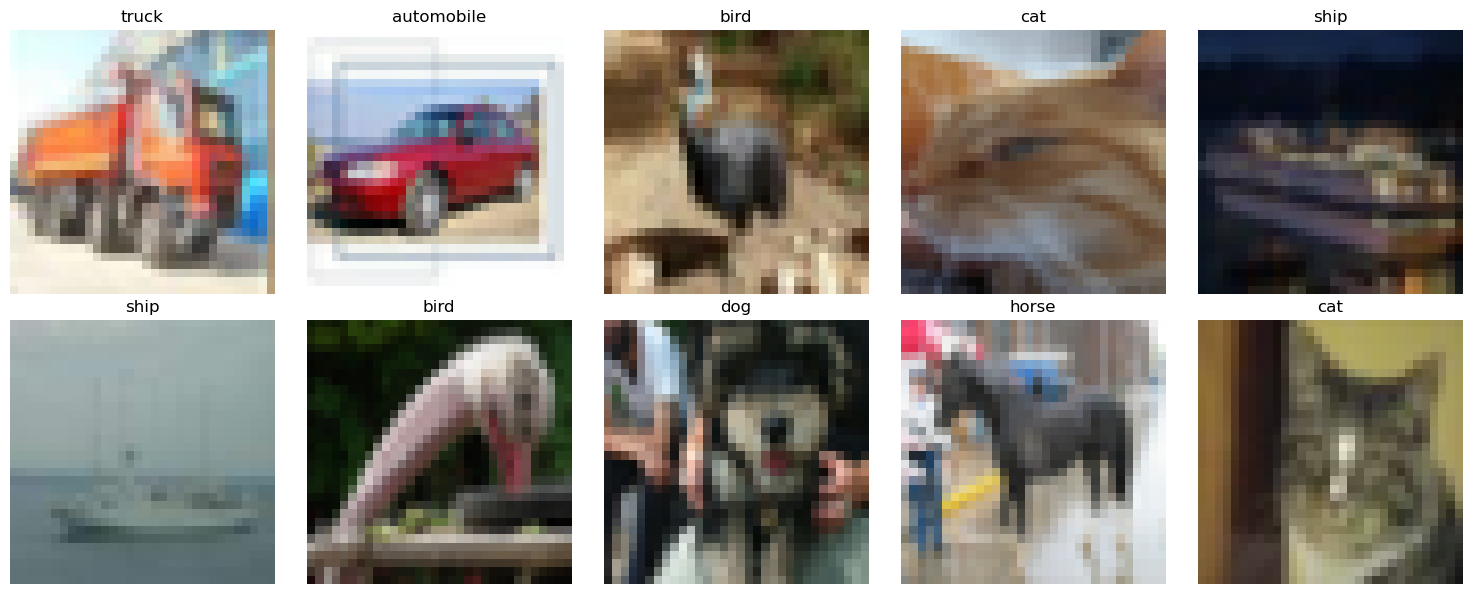

In [19]:
# Plotting a few images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_train[i])
    ax.set_title(label_names[np.argmax(y_train[i])])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Task 2.3: Build a CNN for classifying the CIFAR-10 dataset

Feel free to take inspiration from one of the famous architectures such as LeNet. If you do, please describe where you take inspiration from and give short descriptions on your choice of architecture. 

In [32]:
# Define the F1 Score metric for 10 classes (CIFAR-10)
f1_score_metric = F1Score(num_classes=10, average='macro')

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# SGD Optimizer with momentum and adjusted learning_rate parameter
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score_metric])

# Learning Rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the model
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test F1 Score: {f1_score:.2f}")

Epoch 1/30
625/625 [==============================] - 55s 86ms/step - loss: 1.8762 - accuracy: 0.3198 - f1_score: 0.3168 - val_loss: 1.6990 - val_accuracy: 0.3747 - val_f1_score: 0.3530 - lr: 0.0100
Epoch 2/30
625/625 [==============================] - 53s 85ms/step - loss: 1.5735 - accuracy: 0.4351 - f1_score: 0.4329 - val_loss: 1.3064 - val_accuracy: 0.5415 - val_f1_score: 0.5363 - lr: 0.0100
Epoch 3/30
625/625 [==============================] - 61s 98ms/step - loss: 1.4034 - accuracy: 0.4949 - f1_score: 0.4938 - val_loss: 1.7294 - val_accuracy: 0.4593 - val_f1_score: 0.4433 - lr: 0.0100
Epoch 4/30
625/625 [==============================] - 62s 99ms/step - loss: 1.2792 - accuracy: 0.5430 - f1_score: 0.5428 - val_loss: 1.0751 - val_accuracy: 0.6159 - val_f1_score: 0.6153 - lr: 0.0100
Epoch 5/30
625/625 [==============================] - 56s 89ms/step - loss: 1.1815 - accuracy: 0.5816 - f1_score: 0.5808 - val_loss: 1.0830 - val_accuracy: 0.6089 - val_f1_score: 0.6105 - lr: 0.0100
Epoch

## Task 2.4: Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard

In [33]:
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission_G22.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

313/313 [==============================] - 5s 15ms/step


# Task 2.5: CIFAR-10 Discussion

How did you proceed to develop your CNN model for classifying the CIFAR-10 dataset? What challenges did you face when designing the network? 

#### Model development process
We began with a classic LeNet-inspired architecture since it's a popular starting point for image classification tasks. Because of the complexity of the CIFAR-10 dataset, we used data augmentation to artificially expand the dataset. To improve performance, more convolutional layers were added and batch normalization were used. Dropout layers were also added in order to reduce overfitting. We used SGD optimizer momentum, which achieved better results than a plain gradient descent. A learning rate scheduler was used to reduce the learning rate during training. This helps in better convergence. We iteratively refined the architecture based on our monitoring of the accuracy and F1 score on the validation set. 

#### Challenges faced
We faced a few challenges in this assignment. The most prominent one was overfitting, which was later reduced using dropout layers and just plain simplification of the network. The model was also very computationally expensive at the beginning, and we needed to balance complexity with the available resources on our machines. We also went through a fase of trials and errors considering hyperparameter tuning, which was a challenging and time consuming process. Also, since the CIFAR-10 images has quite low resolution, we struggled a bit achieving a high accuracy on such diverse data with small images.